In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import imread, IMREAD_GRAYSCALE
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from sklearn.utils import compute_class_weight
from utils import *
from models.cnn import CNN
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from PIL import Image
import captum
from captum.attr import GuidedGradCam, GuidedBackprop
from captum.attr import LayerActivation, LayerConductance, LayerGradCam

In [2]:
dataset = get_data()
dataset = dataset[~dataset['filename'].str.contains('DS_Store')]

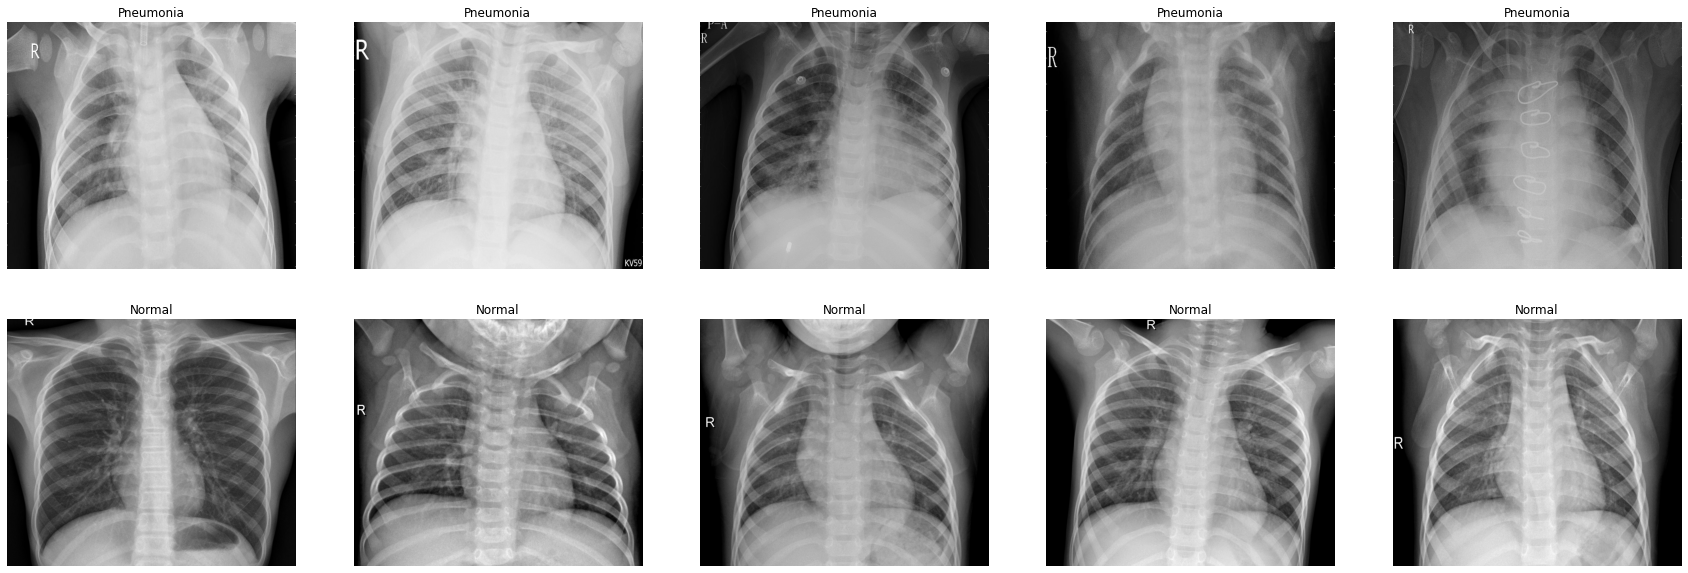

In [39]:
pneumonia_samples = dataset[dataset['class']==1]['filename'].iloc[:5]
normal_samples = dataset[dataset['class']==0]['filename'].iloc[:5]

samples = pd.concat([pneumonia_samples, normal_samples]).to_list()

_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i], IMREAD_GRAYSCALE)
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

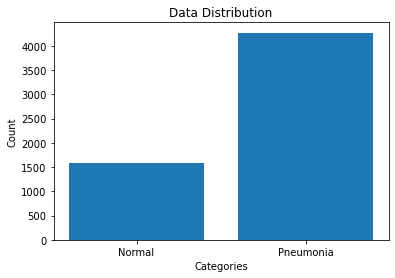

In [5]:
# Plot Image Distribution
categories = ['Normal', 'Pneumonia']
frequencies = list(dataset['class'].value_counts())[::-1]
plt.bar(categories, frequencies)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title('Data Distribution')
plt.show()

In [3]:
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.00175
REGULARIZATION = 1e-4
IMG_SIZE = (96, 96)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {DEVICE.type}')

Using the cpu


In [3]:
data_transforms = transforms.Compose([
    ToTensor(),
    transforms.RandomAffine(degrees=0, shear=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [4]:
train_split = dataset.iloc[:round(len(dataset) * 0.8)]
val_split = dataset.iloc[round(len(dataset) * 0.8): round(len(dataset) * 0.9)]
test_split = dataset.iloc[round(len(dataset) * 0.9):]

train_dataloader = get_dataloader(train_split, BATCH_SIZE, transform=data_transforms)
val_dataloader = get_dataloader(val_split, BATCH_SIZE)
test_dataloader = get_dataloader(test_split, BATCH_SIZE, shuffle=False)

# For batch
nextDataTest = next(iter(test_dataloader))

NameError: name 'BATCH_SIZE' is not defined

In [6]:
model = CNN().to(DEVICE)
print(f"Model summary\n-------------------------------\n{model}")

Model summary
-------------------------------
CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6400, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
history = {
    'losses': [],
    'val_losses': [],
    'accuracies':[],
    'val_accuracies':[],
    'precisions': [],
    'val_precisions': [],
    'recalls': [],
    'val_recalls': [],
    'specificities': [],
    'val_specificities': [],
}

In [27]:
model2 = torch.load('./trained_models/class_weights.pth', map_location=torch.device('cpu'))
print(f"Model summary\n-------------------------------\n{model2}")

Model summary
-------------------------------
CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6400, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [13]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(
        train_dataloader,
        model,
        optimizer,
        DEVICE,
        history
    )
    evaluate(
        val_dataloader,
        model,
        DEVICE,
        history
    )
print("Done!")

Epoch 1
-------------------------------
loss: 0.704613  [    0/ 4685]
loss: 0.570972  [  320/ 4685]


KeyboardInterrupt: 

In [15]:
print('Evaluating on Test Data\n-----------------------------')
y_pred, y_true = evaluate(
    test_dataloader,
    model,
    DEVICE,
    history,
    mode='test'
)

Evaluating on Test Data
-----------------------------
Test Metrics:
Loss: 0.122314, Accuracy: 94.5%, Precision: 97.7%, Recall: 95.7%, Specificity: 87.9%



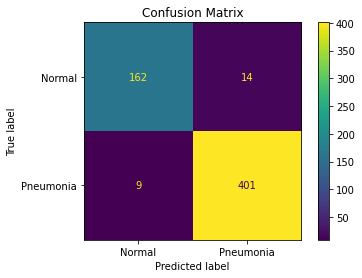

In [14]:
plot_confusion_matrix(y_pred, y_true)

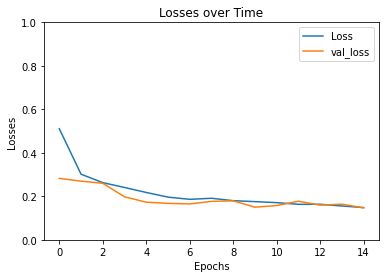

In [15]:
plt.plot(history['losses'], label='Loss')
plt.plot(history['val_losses'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim(0, 1)
plt.title("Losses over Time")
plt.legend()
plt.show()

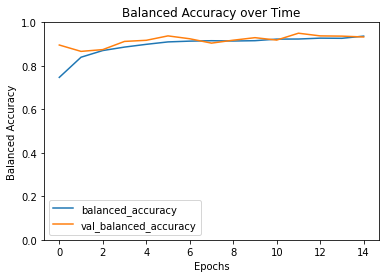

In [16]:
plt.plot(history['accuracies'], label='balanced_accuracy')
plt.plot(history['val_accuracies'], label = 'val_balanced_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.ylim(0, 1)
plt.title("Balanced Accuracy over Time")
plt.legend()
plt.show()

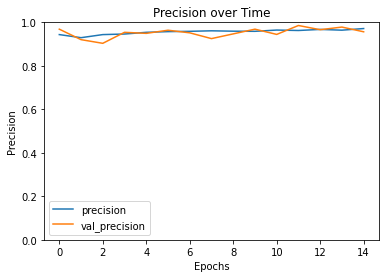

In [17]:
plt.plot(history['precisions'], label='precision')
plt.plot(history['val_precisions'], label = 'val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title("Precision over Time")
plt.legend()
plt.show()

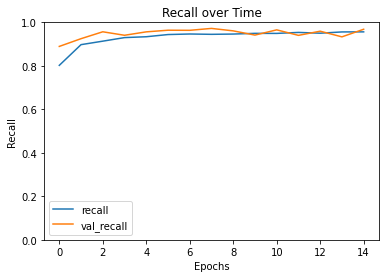

In [18]:
plt.plot(history['recalls'], label='recall')
plt.plot(history['val_recalls'], label = 'val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.title("Recall over Time")
plt.legend()
plt.show()

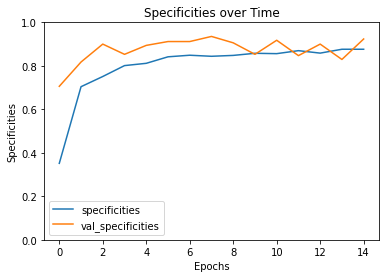

In [19]:
plt.plot(history['specificities'], label='specificities')
plt.plot(history['val_specificities'], label = 'val_specificities')
plt.xlabel('Epochs')
plt.ylabel('Specificities')
plt.ylim(0, 1)
plt.title("Specificities over Time")
plt.legend()
plt.show()

In [20]:
_ = save_model(model, './trained_models/model.pth', history)

In [9]:
# Using Class Weights
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.00175
REGULARIZATION = 1e-4
IMG_SIZE = (96, 96)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
class_weights_model = CNN().to(DEVICE)

In [23]:
optimizer = torch.optim.Adam(class_weights_model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
class_weights_history = {
    'losses': [],
    'val_losses': [],
    'accuracies':[],
    'val_accuracies':[],
    'precisions': [],
    'val_precisions': [],
    'recalls': [],
    'val_recalls': [],
    'specificities': [],
    'val_specificities': [],
}
class_weights = compute_class_weight('balanced', classes=np.unique(train_split['class']), y=train_split['class'])

In [24]:
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(
        train_dataloader,
        class_weights_model,
        optimizer,
        DEVICE,
        class_weights_history,
        class_weights=class_weights
    )
    evaluate(
        val_dataloader,
        class_weights_model,
        DEVICE,
        class_weights_history,
        class_weights=class_weights
    )
print("Done!")

Epoch 1
-------------------------------
loss: 0.733696  [    0/ 4685]
loss: 0.608690  [  320/ 4685]
loss: 0.652462  [  640/ 4685]
loss: 0.776643  [  960/ 4685]
loss: 0.705925  [ 1280/ 4685]
loss: 0.683707  [ 1600/ 4685]
loss: 0.826076  [ 1920/ 4685]
loss: 0.682347  [ 2240/ 4685]
loss: 0.754061  [ 2560/ 4685]
loss: 0.705338  [ 2880/ 4685]
loss: 0.675472  [ 3200/ 4685]
loss: 0.663914  [ 3520/ 4685]
loss: 0.653269  [ 3840/ 4685]
loss: 0.412203  [ 4160/ 4685]
loss: 0.832535  [ 4480/ 4685]
Test Metrics:
Loss: 0.423433, Accuracy: 76.8%, Precision: 77.8%, Recall: 92.6%, Specificity: 84.7%

Epoch 2
-------------------------------
loss: 0.411441  [    0/ 4685]
loss: 0.524103  [  320/ 4685]
loss: 0.494847  [  640/ 4685]
loss: 0.410116  [  960/ 4685]
loss: 0.620007  [ 1280/ 4685]
loss: 0.467840  [ 1600/ 4685]
loss: 0.269254  [ 1920/ 4685]
loss: 0.272210  [ 2240/ 4685]
loss: 0.523379  [ 2560/ 4685]
loss: 0.429400  [ 2880/ 4685]
loss: 0.301436  [ 3200/ 4685]
loss: 0.469506  [ 3520/ 4685]
loss: 0.21

In [25]:
print('Evaluating on Test Data\n-----------------------------')
y_pred, y_true = evaluate(
    test_dataloader,
    class_weights_model,
    DEVICE,
    class_weights_history,
    mode='test',
    class_weights=class_weights
)

Evaluating on Test Data
-----------------------------
Test Metrics:
Loss: 0.195024, Accuracy: 93.3%, Precision: 96.8%, Recall: 94.5%, Specificity: 86.9%



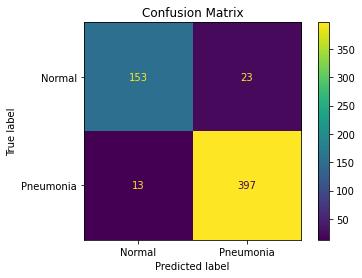

In [26]:
plot_confusion_matrix(y_pred, y_true)

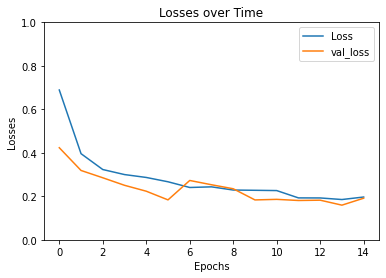

In [27]:
plt.plot(class_weights_history['losses'], label='Loss')
plt.plot(class_weights_history['val_losses'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim(0, 1)
plt.title("Losses over Time")
plt.legend()
plt.show()

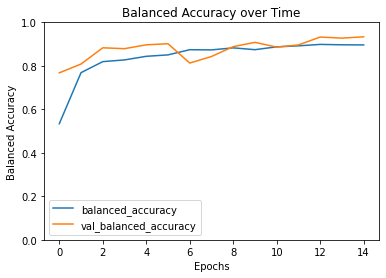

In [28]:
plt.plot(class_weights_history['accuracies'], label='balanced_accuracy')
plt.plot(class_weights_history['val_accuracies'], label = 'val_balanced_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.ylim(0, 1)
plt.title("Balanced Accuracy over Time")
plt.legend()
plt.show()

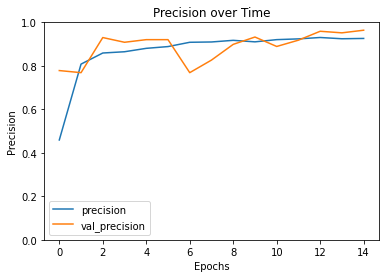

In [29]:
plt.plot(class_weights_history['precisions'], label='precision')
plt.plot(class_weights_history['val_precisions'], label = 'val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title("Precision over Time")
plt.legend()
plt.show()

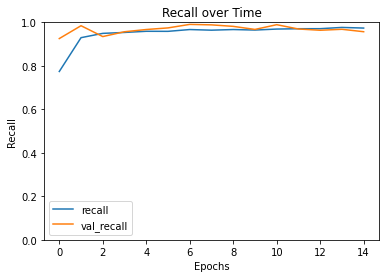

In [30]:
plt.plot(class_weights_history['recalls'], label='recall')
plt.plot(class_weights_history['val_recalls'], label = 'val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.title("Recall over Time")
plt.legend()
plt.show()

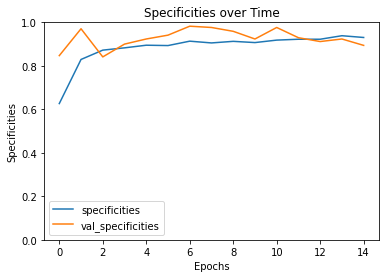

In [31]:
plt.plot(class_weights_history['specificities'], label='specificities')
plt.plot(class_weights_history['val_specificities'], label = 'val_specificities')
plt.xlabel('Epochs')
plt.ylabel('Specificities')
plt.ylim(0, 1)
plt.title("Specificities over Time")
plt.legend()
plt.show()

In [32]:
_ = save_model(class_weights_model, './trained_models/class_weights.pth', class_weights_history, used_weights=True)

In [28]:
l = [module for module in model2.modules() if not isinstance(module, torch.nn.Sequential)]
print(l)
#print(l[9])
#print(type(l[9]))
#print(len(nextDataTest))
#x = x.transpose(1, 3)
#print(torch.nn.Conv2d)

[CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6400, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
  )
), Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid), LeakyReLU(nega

In [9]:
image = Image.open('./data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg')
print(image.format)
print(image.size)
print(image.mode)
npImage = np.asarray(img)
print(type(npImage))
print(npImage.shape)

JPEG
(944, 640)
L


NameError: name 'img' is not defined

In [38]:
#size = (128, 128)
size = (96, 96)

img_path, label = './data/chest_xray/test/PNEUMONIA/person20_virus_51.jpeg', 1
img_path2, label2 = './data/chest_xray/test/NORMAL/im-0001-0001.jpeg', 0
img = imread(img_path, IMREAD_GRAYSCALE)
img2 = imread(img_path2, IMREAD_GRAYSCALE)

img = resize(img, size)
img2 = resize(img2, size)

temp = ToTensor()
imgTens = temp(img)
imgTens = torch.unsqueeze(imgTens, 1)
img = np.reshape(img, (96, 96, 1))
#img = np.reshape(img, (128, 128, 1))
print(img.shape)
print(imgTens.size())
imgTens2 = temp(img2)
imgTens2 = torch.unsqueeze(imgTens2, 1)
img2 = np.reshape(img2, (96, 96, 1))
#img2 = np.reshape(img2, (128, 128, 1))

(96, 96, 1)
torch.Size([1, 1, 96, 96])


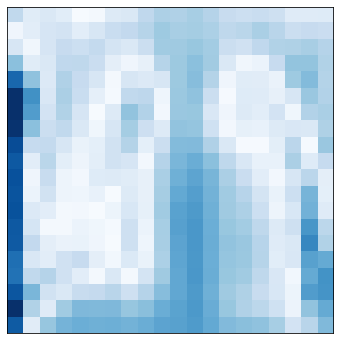

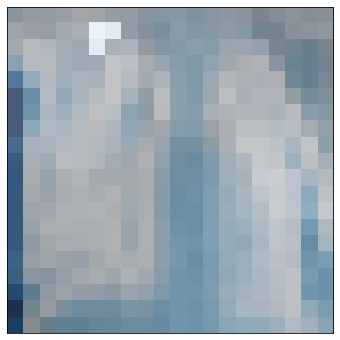

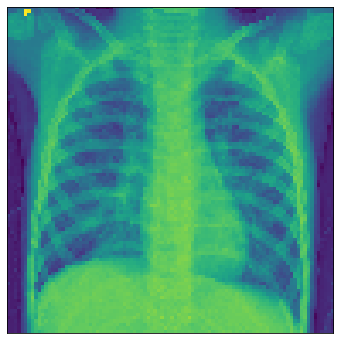

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [45]:
guided_gradcam = GuidedGradCam(model2, l[9])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='original_image')

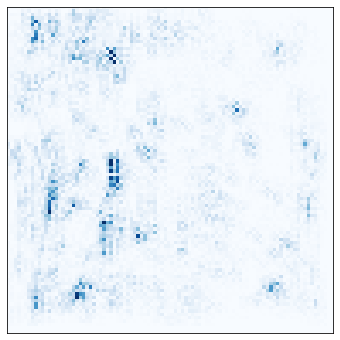

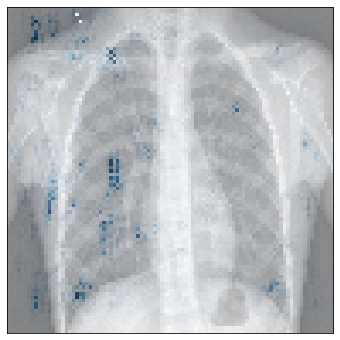

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [31]:
guided_gradcam = GuidedBackprop(model2)
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')

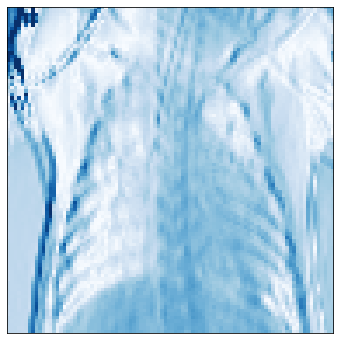

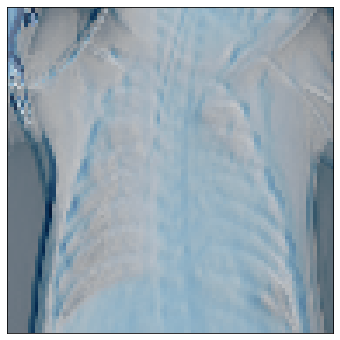

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [162]:
guided_gradcam = LayerGradCam(model2, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')

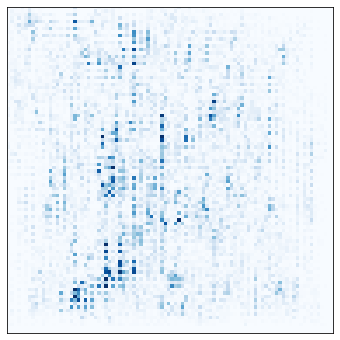

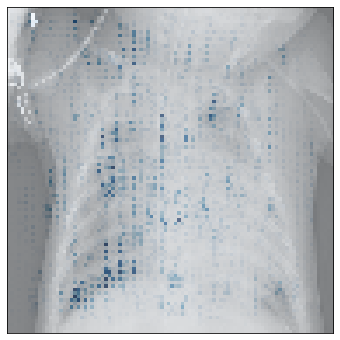

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [163]:
guided_gradcam = LayerConductance(model2, l[1])
attribution = guided_gradcam.attribute(imgTens)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img, method='blended_heat_map')

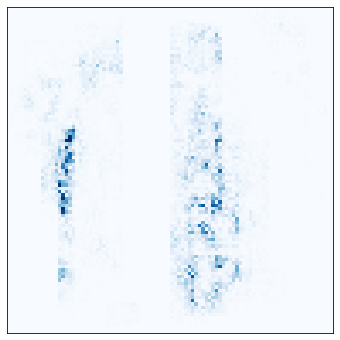

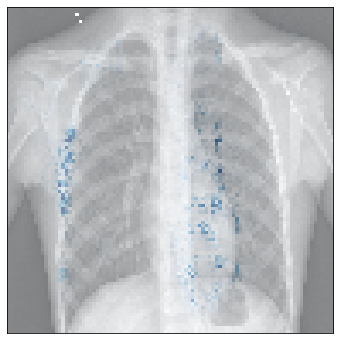

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [149]:
guided_gradcam = GuidedGradCam(model, l[9])
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')

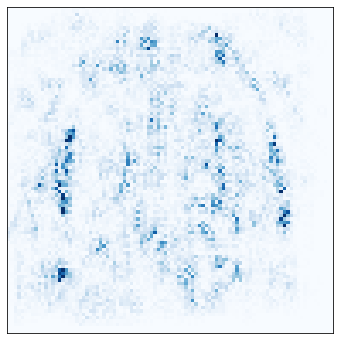

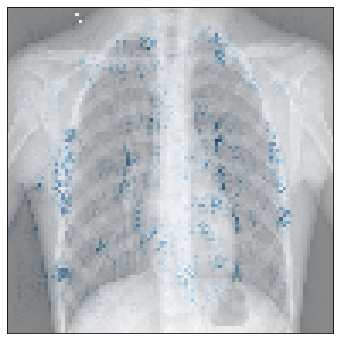

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [155]:
guided_gradcam = GuidedBackprop(model2)
attribution = guided_gradcam.attribute(imgTens2)
attribution = torch.squeeze(attribution, 0)
attribution = attribution.cpu().detach().numpy()

attribution = attribution.transpose((1, 2, 0))
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='heat_map')
captum.attr.visualization.visualize_image_attr(attribution, original_image=img2, method='blended_heat_map')